In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import numpy as np
import nltk
import torch
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tqdm import tqdm, trange

!pip install transformers
import transformers
from transformers import AutoModel, BertTokenizerFast, BertTokenizer, BertForSequenceClassification

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 71.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 27.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 101.1 MB/s eta 0:00:00


In [4]:
# create train test and validation

trainAmt = 0.7
validationTestRatio = 0.5

with open('/content/drive/MyDrive/Datasets/Autextification_datasets/subtask_1/es/train.tsv', 'r') as f:
  allData = f.readlines()

np.random.shuffle(allData)

trainIdx = int(np.floor(len(allData) * trainAmt))
valIdx = int(np.floor(len(allData) * (1 - trainAmt) * validationTestRatio) + trainIdx)

In [5]:
text = []
labels = []

for datum in tqdm(allData):
  _, s, lbl = datum[:-1].split('\t')
  text.append(s)
  labels.append(1 if lbl == 'generated' else 0)

100%|██████████| 32063/32063 [00:00<00:00, 404807.68it/s]


In [6]:
token_id = []
attention_masks = []

def preprocessing(input_text, tokenizer):
  '''
  Returns <class transformers.tokenization_utils_base.BatchEncoding> with the following fields:
    - input_ids: list of token ids
    - token_type_ids: list of token type ids
    - attention_mask: list of indices (0,1) specifying which tokens should considered by the model (return_attention_mask = True).
  '''
  return tokenizer.encode_plus(
                        input_text,
                        add_special_tokens = True,
                        max_length = 90,
                        pad_to_max_length = True,
                        return_attention_mask = True,
                        return_tensors = 'pt'
                   )


tokenizer = BertTokenizer.from_pretrained(
    'dccuchile/bert-base-spanish-wwm-cased',
    do_lower_case = True
    )

for sample in tqdm(text):
  encoding_dict = preprocessing(sample, tokenizer)
  token_id.append(encoding_dict['input_ids']) 
  attention_masks.append(encoding_dict['attention_mask'])


token_id = torch.cat(token_id, dim = 0)
attention_masks = torch.cat(attention_masks, dim = 0)
labels = torch.tensor(labels)

  0%|          | 0/32063 [00:00<?, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
100%|██████████| 32063/32063 [00:59<00:00, 541.10it/s]


In [7]:
# split into train val and test

valntest_ratio = 0.3
valtest_split = 0.5
batch_size = 16

# Indices of the train and validation splits stratified by labels
train_idx, temp_idx = train_test_split(
    np.arange(len(labels)),
    test_size = valntest_ratio,
    shuffle = True,
    stratify = labels)

val_idx, test_idx = train_test_split(
    np.arange(len(labels[temp_idx])),
    test_size = valtest_split,
    shuffle = True,
    stratify = labels[temp_idx])

# Train and validation sets
train_set = TensorDataset(token_id[train_idx], 
                          attention_masks[train_idx], 
                          labels[train_idx])

val_set = TensorDataset(token_id[val_idx], 
                        attention_masks[val_idx], 
                        labels[val_idx])

test_set = TensorDataset(token_id[test_idx], 
                        attention_masks[test_idx], 
                        labels[test_idx])


# Prepare DataLoader
train_dataloader = DataLoader(
            train_set,
            sampler = RandomSampler(train_set),
            batch_size = batch_size
        )

validation_dataloader = DataLoader(
            val_set,
            sampler = SequentialSampler(val_set),
            batch_size = batch_size
        )

validation_dataloader = DataLoader(
            test_set,
            sampler = SequentialSampler(test_set),
            batch_size = batch_size
        )

<Axes: >

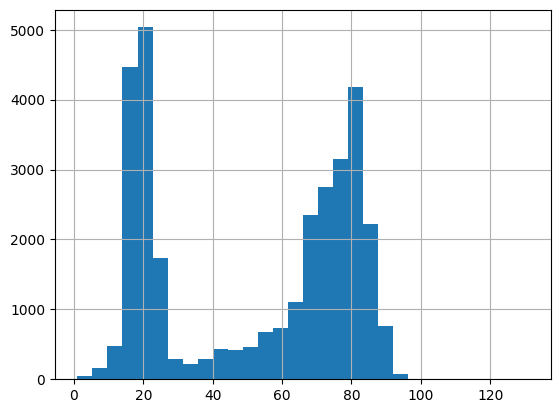

In [8]:
import pandas as pd

seq_len = [len(i.split()) for i in text]

pd.Series(seq_len).hist(bins = 30)

In [9]:
def b_tp(preds, labels):
  '''Returns True Positives (TP): count of correct predictions of actual class 1'''
  return sum([preds == labels and preds == 1 for preds, labels in zip(preds, labels)])

def b_fp(preds, labels):
  '''Returns False Positives (FP): count of wrong predictions of actual class 1'''
  return sum([preds != labels and preds == 1 for preds, labels in zip(preds, labels)])

def b_tn(preds, labels):
  '''Returns True Negatives (TN): count of correct predictions of actual class 0'''
  return sum([preds == labels and preds == 0 for preds, labels in zip(preds, labels)])

def b_fn(preds, labels):
  '''Returns False Negatives (FN): count of wrong predictions of actual class 0'''
  return sum([preds != labels and preds == 0 for preds, labels in zip(preds, labels)])

def b_metrics(preds, labels):
  '''
  Returns the following metrics:
    - accuracy    = (TP + TN) / N
    - precision   = TP / (TP + FP)
    - recall      = TP / (TP + FN)
    - specificity = TN / (TN + FP)
  '''
  preds = np.argmax(preds, axis = 1).flatten()
  labels = labels.flatten()
  tp = b_tp(preds, labels)
  tn = b_tn(preds, labels)
  fp = b_fp(preds, labels)
  fn = b_fn(preds, labels)
  b_accuracy = (tp + tn) / len(labels)
  b_precision = tp / (tp + fp) if (tp + fp) > 0 else 'nan'
  b_recall = tp / (tp + fn) if (tp + fn) > 0 else 'nan'
  b_specificity = tn / (tn + fp) if (tn + fp) > 0 else 'nan'
  return b_accuracy, b_precision, b_recall, b_specificity

In [10]:
# Load the BertForSequenceClassification model
model = BertForSequenceClassification.from_pretrained(
    'dccuchile/bert-base-spanish-wwm-cased',
    num_labels = 2,
    output_attentions = False,
    output_hidden_states = False,
)

# Recommended learning rates (Adam): 5e-5, 3e-5, 2e-5. See: https://arxiv.org/pdf/1810.04805.pdf
optimizer = torch.optim.AdamW(model.parameters(), 
                              lr = 5e-5,
                              eps = 1e-08
                              )

lossFn = nn.CrossEntropyLoss()

model.to('cuda')

Some weights of the model checkpoint at dccuchile/bert-base-spanish-wwm-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchi

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(31002, 768, padding_idx=1)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

# Train naive single BERT

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

epochs = 2

print("Set length: ", len(train_dataloader))
for _ in trange(epochs, desc = 'Epoch'):
    
    # ========== Training ==========
    
    # Set model to training mode
    model.train()
    
    # Tracking variables
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0

    updator = 100
    for step, batch in enumerate(train_dataloader):
        if (step+1) % updator == 0:
          print("Step: ", step)

        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        optimizer.zero_grad()
        # Forward pass
        train_output = model(b_input_ids, 
                             token_type_ids = None, 
                             attention_mask = b_input_mask, 
                             labels = b_labels)
        # Backward pass
        # print("Logits: ", train_output.logits)
        # print("Labels: ", b_labels)

        cntLoss = lossFn(train_output.logits, b_labels)

        cntLoss.backward()
        optimizer.step()
        # Update tracking variables
        tr_loss += cntLoss
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1

        # print("Loss: ", train_output.loss)
        # print("My loss", cntLoss)

    # ========== Validation ==========

    # Set model to evaluation mode
    model.eval()

    # Tracking variables 
    val_accuracy = []
    val_precision = []
    val_recall = []
    val_specificity = []

    for batch in validation_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        with torch.no_grad():
          # Forward pass
          eval_output = model(b_input_ids, 
                              token_type_ids = None, 
                              attention_mask = b_input_mask)
        logits = eval_output.logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        # Calculate validation metrics
        b_accuracy, b_precision, b_recall, b_specificity = b_metrics(logits, label_ids)
        val_accuracy.append(b_accuracy)
        # Update precision only when (tp + fp) !=0; ignore nan
        if b_precision != 'nan': val_precision.append(b_precision)
        # Update recall only when (tp + fn) !=0; ignore nan
        if b_recall != 'nan': val_recall.append(b_recall)
        # Update specificity only when (tn + fp) !=0; ignore nan
        if b_specificity != 'nan': val_specificity.append(b_specificity)

    print('\n\t - Train loss: {:.4f}'.format(tr_loss / nb_tr_steps))
    print('\t - Validation Accuracy: {:.4f}'.format(sum(val_accuracy)/len(val_accuracy)))
    print('\t - Validation Precision: {:.4f}'.format(sum(val_precision)/len(val_precision)) if len(val_precision)>0 else '\t - Validation Precision: NaN')
    print('\t - Validation Recall: {:.4f}'.format(sum(val_recall)/len(val_recall)) if len(val_recall)>0 else '\t - Validation Recall: NaN')
    print('\t - Validation Specificity: {:.4f}\n'.format(sum(val_specificity)/len(val_specificity)) if len(val_specificity)>0 else '\t - Validation Specificity: NaN')

Set length:  1403


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Step:  99
Step:  199
Step:  299
Step:  399
Step:  499
Step:  599
Step:  699
Step:  799
Step:  899
Step:  999
Step:  1099
Step:  1199
Step:  1299
Step:  1399


Epoch:  50%|█████     | 1/2 [06:20<06:20, 380.28s/it]


	 - Train loss: 0.3086
	 - Validation Accuracy: 0.9006
	 - Validation Precision: 0.8421
	 - Validation Recall: 0.9942
	 - Validation Specificity: 0.8021

Step:  99
Step:  199
Step:  299
Step:  399
Step:  499
Step:  599
Step:  699
Step:  799
Step:  899
Step:  999
Step:  1099
Step:  1199
Step:  1299
Step:  1399


Epoch: 100%|██████████| 2/2 [12:44<00:00, 382.32s/it]


	 - Train loss: 0.1244
	 - Validation Accuracy: 0.9633
	 - Validation Precision: 0.9581
	 - Validation Recall: 0.9691
	 - Validation Specificity: 0.9576



# Fine tune ensemble BERTs on subtask B
- 6 BERTs, one for each label
- Each one performs binary classification


In [12]:
# preprocess subtask B data

trainAmt = 0.7
validationTestRatio = 0.5

with open('/content/drive/MyDrive/Datasets/Autextification_datasets/subtask_2/es/train.tsv', 'r') as f:
  allData = f.readlines()
allData = allData[1:]

np.random.shuffle(allData)

trainIdx = int(np.floor(len(allData) * trainAmt))
valIdx = int(np.floor(len(allData) * (1 - trainAmt) * validationTestRatio) + trainIdx)

text = []
labels = []

letter2lbl = {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5}

for datum in tqdm(allData):
  _, s, letter = datum[:-1].split('\t')
  text.append(s)
  labels.append(letter2lbl[letter])

100%|██████████| 21935/21935 [00:00<00:00, 356728.48it/s]


In [13]:
# preprocess data

token_id = []
attention_masks = []

def preprocessing(input_text, tokenizer):
  '''
  Returns <class transformers.tokenization_utils_base.BatchEncoding> with the following fields:
    - input_ids: list of token ids
    - token_type_ids: list of token type ids
    - attention_mask: list of indices (0,1) specifying which tokens should considered by the model (return_attention_mask = True).
  '''
  return tokenizer.encode_plus(
                        input_text,
                        add_special_tokens = True,
                        max_length = 90,
                        pad_to_max_length = True,
                        return_attention_mask = True,
                        return_tensors = 'pt'
                   )


tokenizer = BertTokenizer.from_pretrained(
    'dccuchile/bert-base-spanish-wwm-cased',
    do_lower_case = True
    )

for sample in tqdm(text):
  encoding_dict = preprocessing(sample, tokenizer)
  token_id.append(encoding_dict['input_ids']) 
  attention_masks.append(encoding_dict['attention_mask'])


token_id = torch.cat(token_id, dim = 0)
attention_masks = torch.cat(attention_masks, dim = 0)
labels = torch.tensor(labels)

  0%|          | 0/21935 [00:00<?, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
100%|██████████| 21935/21935 [00:30<00:00, 712.40it/s]


In [14]:
# create dataloaders
# split into train val and test

numModels = 6 # ONE FOR EACH CLASS

valntest_ratio = 0.3
valtest_split = 0.5
batch_size = 16

# Indices of the train and validation splits stratified by labels
train_idx, temp_idx = train_test_split(
    np.arange(len(labels)),
    test_size = valntest_ratio,
    shuffle = True,
    stratify = labels)

val_idx, test_idx = train_test_split(
    np.arange(len(labels[temp_idx])),
    test_size = valtest_split,
    shuffle = True,
    stratify = labels[temp_idx])


# Train and validation sets
train_sets = []
val_sets = []
test_sets = []

train_dataloaders = []
validation_dataloaders = []
test_dataloaders = []

a = 100
b = 110

print("OG   ", end='\t')
print(labels[a:b])

# 6 class datasets
six_class_train_set = TensorDataset(token_id[train_idx], 
                          attention_masks[train_idx], 
                          labels[train_idx])

six_class_val_set = TensorDataset(token_id[val_idx], 
                        attention_masks[val_idx], 
                        labels[val_idx])

six_class_test_set = TensorDataset(token_id[test_idx], 
                        attention_masks[test_idx], 
                        labels[test_idx])

six_class_train_dataloader = DataLoader(
              six_class_train_set,
              sampler = RandomSampler(six_class_train_set),
              batch_size = batch_size
          )

six_class_validation_dataloader = DataLoader(
            six_class_val_set,
            sampler = SequentialSampler(six_class_val_set),
            batch_size = batch_size
        )

six_class_test_dataloader = DataLoader(
            six_class_test_set,
            sampler = SequentialSampler(six_class_test_set),
            batch_size = batch_size
        )


# binary classification datasets
for i in range(numModels):
  # label reassignment: i -> 1, not i -> 0
  reassignedLabels = torch.tensor(np.where(np.array(labels) == i, 1, 0))

  print("LABEL %d" % i, end='\t')
  print(reassignedLabels[a:b])
  
  train_sets.append(TensorDataset(token_id[train_idx], 
                            attention_masks[train_idx], 
                            reassignedLabels[train_idx]))

  val_sets.append(TensorDataset(token_id[val_idx], 
                          attention_masks[val_idx], 
                          reassignedLabels[val_idx]))

  test_sets.append(TensorDataset(token_id[test_idx], 
                          attention_masks[test_idx], 
                          reassignedLabels[test_idx]))


  # Prepare DataLoader
  train_dataloaders.append(DataLoader(
              train_sets[i],
              sampler = RandomSampler(train_sets[i]),
              batch_size = batch_size
          ))

  validation_dataloaders.append(DataLoader(
              val_sets[i],
              sampler = SequentialSampler(val_sets[i]),
              batch_size = batch_size
          ))

  test_dataloaders.append(DataLoader(
              test_sets[i],
              sampler = SequentialSampler(test_sets[i]),
              batch_size = batch_size
          ))
  
  print("counts: ", end='\t')
  counts = [0,0,0,0,0,0]
  for el in tqdm(reassignedLabels):
    counts[el] += 1
  print(counts)

  print("lens: ", len(train_dataloaders[i]), len(validation_dataloaders[i]), len(test_dataloaders[i]))
  print()


OG   	tensor([3, 0, 0, 0, 4, 0, 2, 0, 3, 2])
LABEL 0	tensor([0, 1, 1, 1, 0, 1, 0, 1, 0, 0])
counts: 	

100%|██████████| 21935/21935 [00:00<00:00, 137454.99it/s]


[18513, 3422, 0, 0, 0, 0]
lens:  960 206 206

LABEL 1	tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
counts: 	

100%|██████████| 21935/21935 [00:00<00:00, 162424.98it/s]


[18421, 3514, 0, 0, 0, 0]
lens:  960 206 206

LABEL 2	tensor([0, 0, 0, 0, 0, 0, 1, 0, 0, 1])
counts: 	

100%|██████████| 21935/21935 [00:00<00:00, 61235.71it/s]


[18360, 3575, 0, 0, 0, 0]
lens:  960 206 206

LABEL 3	tensor([1, 0, 0, 0, 0, 0, 0, 0, 1, 0])
counts: 	

100%|██████████| 21935/21935 [00:00<00:00, 163665.71it/s]


[18147, 3788, 0, 0, 0, 0]
lens:  960 206 206

LABEL 4	tensor([0, 0, 0, 0, 1, 0, 0, 0, 0, 0])
counts: 	

100%|██████████| 21935/21935 [00:00<00:00, 170701.04it/s]


[18165, 3770, 0, 0, 0, 0]
lens:  960 206 206

LABEL 5	tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
counts: 	

100%|██████████| 21935/21935 [00:00<00:00, 165314.04it/s]

[18069, 3866, 0, 0, 0, 0]
lens:  960 206 206



In [15]:
# evaluation functions

def b_tp(preds, labels):
  '''Returns True Positives (TP): count of correct predictions of actual class 1'''
  return sum([preds == labels and preds == 1 for preds, labels in zip(preds, labels)])

def b_fp(preds, labels):
  '''Returns False Positives (FP): count of wrong predictions of actual class 1'''
  return sum([preds != labels and preds == 1 for preds, labels in zip(preds, labels)])

def b_tn(preds, labels):
  '''Returns True Negatives (TN): count of correct predictions of actual class 0'''
  return sum([preds == labels and preds == 0 for preds, labels in zip(preds, labels)])

def b_fn(preds, labels):
  '''Returns False Negatives (FN): count of wrong predictions of actual class 0'''
  return sum([preds != labels and preds == 0 for preds, labels in zip(preds, labels)])

def b_metrics(preds, labels):
  '''
  Returns the following metrics:
    - accuracy    = (TP + TN) / N
    - precision   = TP / (TP + FP)
    - recall      = TP / (TP + FN)
    - specificity = TN / (TN + FP)
  '''
  preds = np.argmax(preds, axis = 1).flatten()
  labels = labels.flatten()
  tp = b_tp(preds, labels)
  tn = b_tn(preds, labels)
  fp = b_fp(preds, labels)
  fn = b_fn(preds, labels)
  b_accuracy = (tp + tn) / len(labels)
  b_precision = tp / (tp + fp) if (tp + fp) > 0 else 'nan'
  b_recall = tp / (tp + fn) if (tp + fn) > 0 else 'nan'
  b_specificity = tn / (tn + fp) if (tn + fp) > 0 else 'nan'
  return b_accuracy, b_precision, b_recall, b_specificity

In [16]:
# 6 class BERT
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

six_bert = BertForSequenceClassification.from_pretrained(
    'dccuchile/bert-base-spanish-wwm-cased',
    num_labels = 6,
    output_attentions = False,
    output_hidden_states = False,
  ).to(device)

model = six_bert
optimizer = torch.optim.AdamW(model.parameters(), 
                            lr = 5e-5,
                            eps = 1e-08
                            )
lossFn = nn.CrossEntropyLoss().cuda()
epochs = 2

for _ in trange(epochs, desc = 'Epoch'):
    # ========== Training ==========
    
    # Set model to training mode
    model.train()
    
    # Tracking variables
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0

    updator=100
    for step, batch in enumerate(six_class_train_dataloader):
        if (step + 1) % 100 == 0:
          print("Step: ", step)

        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        optimizer.zero_grad()
        # Forward pass
        train_output = model(b_input_ids, 
                            token_type_ids = None, 
                            attention_mask = b_input_mask, 
                            labels = b_labels)

        # Backward pass
        cntLoss = lossFn(train_output.logits, b_labels)
        cntLoss.backward()

        optimizer.step()
        # Update tracking variables
        tr_loss += cntLoss
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1

    # ========== Validation ==========

    # Set model to evaluation mode
    model.eval()

    # Tracking variables 
    val_accuracy = []
    val_precision = []
    val_recall = []
    val_specificity = []

    all_labels = np.array([])
    all_preds = np.array([])

    for batch in six_class_validation_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        with torch.no_grad():
          # Forward pass
          eval_output = model(b_input_ids, 
                              token_type_ids = None, 
                              attention_mask = b_input_mask)
        logits = eval_output.logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        all_labels = np.append(all_labels, label_ids)
        all_preds = np.append(all_preds, np.argmax(logits, axis = 1).flatten())
        # Calculate validation metrics
        b_accuracy, b_precision, b_recall, b_specificity = b_metrics(logits, label_ids)
        val_accuracy.append(b_accuracy)
        # Update precision only when (tp + fp) !=0; ignore nan
        if b_precision != 'nan': val_precision.append(b_precision)
        # Update recall only when (tp + fn) !=0; ignore nan
        if b_recall != 'nan': val_recall.append(b_recall)
        # Update specificity only when (tn + fp) !=0; ignore nan
        if b_specificity != 'nan': val_specificity.append(b_specificity)

    print('\n\t - Train loss: {:.4f}'.format(tr_loss / nb_tr_steps))
    print('\t - Validation Accuracy: {:.4f}'.format(sum(val_accuracy)/len(val_accuracy)))
    print('\t - Validation Precision: {:.4f}'.format(sum(val_precision)/len(val_precision)) if len(val_precision)>0 else '\t - Validation Precision: NaN')
    print('\t - Validation Recall: {:.4f}'.format(sum(val_recall)/len(val_recall)) if len(val_recall)>0 else '\t - Validation Recall: NaN')
    print('\t - Validation Specificity: {:.4f}\n'.format(sum(val_specificity)/len(val_specificity)) if len(val_specificity)>0 else '\t - Validation Specificity: NaN')

    from sklearn.metrics import classification_report   
    print(classification_report(all_labels, all_preds))


Some weights of the model checkpoint at dccuchile/bert-base-spanish-wwm-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchi

Step:  99
Step:  199
Step:  299
Step:  399
Step:  499
Step:  599
Step:  699
Step:  799
Step:  899


Epoch:  50%|█████     | 1/2 [04:24<04:24, 264.31s/it]


	 - Train loss: 1.1444
	 - Validation Accuracy: 0.1810
	 - Validation Precision: 0.4337
	 - Validation Recall: 0.8761
	 - Validation Specificity: 0.3722

              precision    recall  f1-score   support

         0.0       0.84      0.52      0.64       485
         1.0       0.43      0.63      0.51       545
         2.0       0.53      0.41      0.46       512
         3.0       0.70      0.19      0.31       513
         4.0       0.55      0.76      0.64       624
         5.0       0.73      0.95      0.82       611

    accuracy                           0.60      3290
   macro avg       0.63      0.58      0.56      3290
weighted avg       0.63      0.60      0.57      3290

Step:  99
Step:  199
Step:  299
Step:  399
Step:  499
Step:  599
Step:  699
Step:  799
Step:  899


Epoch: 100%|██████████| 2/2 [08:48<00:00, 264.12s/it]


	 - Train loss: 0.8174
	 - Validation Accuracy: 0.1908
	 - Validation Precision: 0.6179
	 - Validation Recall: 0.4905
	 - Validation Specificity: 0.7888

              precision    recall  f1-score   support

         0.0       0.67      0.89      0.76       485
         1.0       0.61      0.37      0.46       545
         2.0       0.50      0.71      0.59       512
         3.0       0.67      0.67      0.67       513
         4.0       0.73      0.45      0.56       624
         5.0       0.80      0.92      0.86       611

    accuracy                           0.66      3290
   macro avg       0.67      0.67      0.65      3290
weighted avg       0.67      0.66      0.65      3290



## Ensemble BERT

In [17]:
# define all models

BERTs = []
for i in range(numModels):
  model = BertForSequenceClassification.from_pretrained(
    'dccuchile/bert-base-spanish-wwm-cased',
    num_labels = 2,
    output_attentions = False,
    output_hidden_states = False,
  )
  model.cuda()

  BERTs.append(model)

Some weights of the model checkpoint at dccuchile/bert-base-spanish-wwm-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchi

In [18]:
# train each BERT

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

epochs = 2

print("Trainset length: ", len(train_dataloader))
for bertNum in range(numModels):
  print("TRAINING BERT #%d" % bertNum)

  train_dataloader = train_dataloaders[bertNum]
  validation_dataloader = validation_dataloaders[bertNum]


  print(train_dataloaders[bertNum])

  model = BERTs[bertNum]
  optimizer = torch.optim.AdamW(model.parameters(), 
                              lr = 5e-7,
                              eps = 1e-08
                              )

  classWeights = torch.tensor([1., 100.]).float().cuda()
  print(classWeights)
  lossFn = nn.CrossEntropyLoss(weight=classWeights)

  for _ in trange(epochs, desc = 'Epoch'):
      
      # ========== Training ==========
      
      # Set model to training mode
      model.train()
      
      # Tracking variables
      tr_loss = 0
      nb_tr_examples, nb_tr_steps = 0, 0

      updator=100
      for step, batch in enumerate(train_dataloader):
          if (step + 1) % 100 == 0:
            print("Step: ", step)

          batch = tuple(t.to(device) for t in batch)
          b_input_ids, b_input_mask, b_labels = batch
          optimizer.zero_grad()
          # Forward pass
          train_output = model(b_input_ids, 
                              token_type_ids = None, 
                              attention_mask = b_input_mask, 
                              labels = b_labels)
          # Backward pass
          cntLoss = lossFn(train_output.logits, b_labels)
          cntLoss.backward()

          optimizer.step()
          # Update tracking variables
          tr_loss += cntLoss
          nb_tr_examples += b_input_ids.size(0)
          nb_tr_steps += 1

      # ========== Validation ==========

      # Set model to evaluation mode
      model.eval()

      # Tracking variables 
      val_accuracy = []
      val_precision = []
      val_recall = []
      val_specificity = []

      for batch in validation_dataloader:
          batch = tuple(t.to(device) for t in batch)
          b_input_ids, b_input_mask, b_labels = batch
          with torch.no_grad():
            # Forward pass
            eval_output = model(b_input_ids, 
                                token_type_ids = None, 
                                attention_mask = b_input_mask)
          logits = eval_output.logits.detach().cpu().numpy()
          label_ids = b_labels.to('cpu').numpy()
          # Calculate validation metrics
          b_accuracy, b_precision, b_recall, b_specificity = b_metrics(logits, label_ids)
          val_accuracy.append(b_accuracy)
          # Update precision only when (tp + fp) !=0; ignore nan
          if b_precision != 'nan': val_precision.append(b_precision)
          # Update recall only when (tp + fn) !=0; ignore nan
          if b_recall != 'nan': val_recall.append(b_recall)
          # Update specificity only when (tn + fp) !=0; ignore nan
          if b_specificity != 'nan': val_specificity.append(b_specificity)

      print('\n\t - Train loss: {:.4f}'.format(tr_loss / nb_tr_steps))
      print('\t - Validation Accuracy: {:.4f}'.format(sum(val_accuracy)/len(val_accuracy)))
      print('\t - Validation Precision: {:.4f}'.format(sum(val_precision)/len(val_precision)) if len(val_precision)>0 else '\t - Validation Precision: NaN')
      print('\t - Validation Recall: {:.4f}'.format(sum(val_recall)/len(val_recall)) if len(val_recall)>0 else '\t - Validation Recall: NaN')
      print('\t - Validation Specificity: {:.4f}\n'.format(sum(val_specificity)/len(val_specificity)) if len(val_specificity)>0 else '\t - Validation Specificity: NaN')

Trainset length:  1403
TRAINING BERT #0
tensor([  1., 100.], device='cuda:0')


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Step:  99
Step:  199
Step:  299
Step:  399
Step:  499
Step:  599
Step:  699
Step:  799
Step:  899


Epoch:  50%|█████     | 1/2 [04:24<04:24, 264.30s/it]


	 - Train loss: 0.4118
	 - Validation Accuracy: 0.1471
	 - Validation Precision: 0.1471
	 - Validation Recall: 1.0000
	 - Validation Specificity: 0.0000

Step:  99
Step:  199
Step:  299
Step:  399
Step:  499
Step:  599
Step:  699
Step:  799
Step:  899


Epoch: 100%|██████████| 2/2 [08:48<00:00, 264.29s/it]



	 - Train loss: 0.3607
	 - Validation Accuracy: 0.1502
	 - Validation Precision: 0.1476
	 - Validation Recall: 1.0000
	 - Validation Specificity: 0.0036

TRAINING BERT #1
tensor([  1., 100.], device='cuda:0')


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Step:  99
Step:  199
Step:  299
Step:  399
Step:  499
Step:  599
Step:  699
Step:  799
Step:  899


Epoch:  50%|█████     | 1/2 [04:24<04:24, 264.04s/it]


	 - Train loss: 0.3840
	 - Validation Accuracy: 0.1657
	 - Validation Precision: 0.1657
	 - Validation Recall: 1.0000
	 - Validation Specificity: 0.0000

Step:  99
Step:  199
Step:  299
Step:  399
Step:  499
Step:  599
Step:  699
Step:  799
Step:  899


Epoch: 100%|██████████| 2/2 [08:48<00:00, 264.06s/it]



	 - Train loss: 0.3639
	 - Validation Accuracy: 0.1657
	 - Validation Precision: 0.1657
	 - Validation Recall: 1.0000
	 - Validation Specificity: 0.0000

TRAINING BERT #2
tensor([  1., 100.], device='cuda:0')


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Step:  99
Step:  199
Step:  299
Step:  399
Step:  499
Step:  599
Step:  699
Step:  799
Step:  899


Epoch:  50%|█████     | 1/2 [04:23<04:23, 263.81s/it]


	 - Train loss: 0.4062
	 - Validation Accuracy: 0.1559
	 - Validation Precision: 0.1559
	 - Validation Recall: 1.0000
	 - Validation Specificity: 0.0000

Step:  99
Step:  199
Step:  299
Step:  399
Step:  499
Step:  599
Step:  699
Step:  799
Step:  899


Epoch: 100%|██████████| 2/2 [08:47<00:00, 263.99s/it]



	 - Train loss: 0.3517
	 - Validation Accuracy: 0.1559
	 - Validation Precision: 0.1559
	 - Validation Recall: 1.0000
	 - Validation Specificity: 0.0000

TRAINING BERT #3
tensor([  1., 100.], device='cuda:0')


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Step:  99
Step:  199
Step:  299
Step:  399
Step:  499
Step:  599
Step:  699
Step:  799
Step:  899


Epoch:  50%|█████     | 1/2 [04:24<04:24, 264.02s/it]


	 - Train loss: 0.3610
	 - Validation Accuracy: 0.1558
	 - Validation Precision: 0.1558
	 - Validation Recall: 1.0000
	 - Validation Specificity: 0.0000

Step:  99
Step:  199
Step:  299
Step:  399
Step:  499
Step:  599
Step:  699
Step:  799
Step:  899


Epoch: 100%|██████████| 2/2 [08:48<00:00, 264.13s/it]



	 - Train loss: 0.3026
	 - Validation Accuracy: 0.1995
	 - Validation Precision: 0.1632
	 - Validation Recall: 1.0000
	 - Validation Specificity: 0.0519

TRAINING BERT #4
tensor([  1., 100.], device='cuda:0')


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Step:  99
Step:  199
Step:  299
Step:  399
Step:  499
Step:  599
Step:  699
Step:  799
Step:  899


Epoch:  50%|█████     | 1/2 [04:24<04:24, 264.01s/it]


	 - Train loss: 0.3666
	 - Validation Accuracy: 0.1895
	 - Validation Precision: 0.1895
	 - Validation Recall: 1.0000
	 - Validation Specificity: 0.0000

Step:  99
Step:  199
Step:  299
Step:  399
Step:  499
Step:  599
Step:  699
Step:  799
Step:  899


Epoch: 100%|██████████| 2/2 [08:47<00:00, 263.92s/it]



	 - Train loss: 0.3106
	 - Validation Accuracy: 0.1895
	 - Validation Precision: 0.1895
	 - Validation Recall: 1.0000
	 - Validation Specificity: 0.0000

TRAINING BERT #5
tensor([  1., 100.], device='cuda:0')


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Step:  99
Step:  199
Step:  299
Step:  399
Step:  499
Step:  599
Step:  699
Step:  799
Step:  899


Epoch:  50%|█████     | 1/2 [04:24<04:24, 264.17s/it]


	 - Train loss: 0.3648
	 - Validation Accuracy: 0.1859
	 - Validation Precision: 0.1859
	 - Validation Recall: 1.0000
	 - Validation Specificity: 0.0000

Step:  99
Step:  199
Step:  299
Step:  399
Step:  499
Step:  599
Step:  699
Step:  799
Step:  899


Epoch: 100%|██████████| 2/2 [08:48<00:00, 264.22s/it]


	 - Train loss: 0.2823
	 - Validation Accuracy: 0.1859
	 - Validation Precision: 0.1859
	 - Validation Recall: 1.0000
	 - Validation Specificity: 0.0000



# Hierarchical training

BERT seems to learn how to classify classes 0 and 5 very well, but cant disstinguish between the rest.

We will now try a hierarchical approach, first discriminating between (0,5 and not-0-or-5), and then training a separate model to further classify the not-0-or-5 entries into 1,2,3 and 4 

In [19]:
"""

tree so far:

    ___
   / | \
  0  5  else
        -+-
      / | | \
     1  2 3  4

FIRST BRANCH:
remapping 
1,2,3,4   -> 0
0         -> 1
5         -> 2


SECOND BRANCH:
remapping
1         -> 0
2         -> 1
3         -> 2
4         -> 3

"""

# convert labels to first branch mappings
first_node_labels = torch.tensor(np.zeros_like(labels))
first_node_labels[(labels == 0).nonzero()] = 1
first_node_labels[(labels == 5).nonzero()] = 2


first_node_train_set = TensorDataset(token_id[train_idx], 
                          attention_masks[train_idx], 
                          first_node_labels[train_idx])

first_node_val_set = TensorDataset(token_id[val_idx], 
                        attention_masks[val_idx], 
                        first_node_labels[val_idx])

first_node_test_set = TensorDataset(token_id[test_idx], 
                        attention_masks[test_idx], 
                        first_node_labels[test_idx])

first_node_train_dataloader = DataLoader(
            first_node_train_set,
            sampler = RandomSampler(first_node_train_set),
            batch_size = batch_size
        )

first_node_validation_dataloader = DataLoader(
            first_node_val_set,
            sampler = SequentialSampler(first_node_val_set),
            batch_size = batch_size
        )

first_node_test_dataloader = DataLoader(
            first_node_test_set,
            sampler = SequentialSampler(first_node_test_set),
            batch_size = batch_size
        )
  
print("first branch counts: ", end='\t')
counts = [0,0,0,0,0,0]
for el in tqdm(first_node_labels):
  counts[el] += 1
print(counts)

print("lens: ", len(first_node_train_dataloader), len(first_node_validation_dataloader), len(first_node_test_dataloader))
print()


# get only second node branch mappings
# second_node_labels = labels[labels != 0]
# second_node_labels = second_node_labels[second_node_labels != 5]

# temp = np.copy(second_node_labels)
# second_node_labels[(temp == 1).nonzero()] = 0
# second_node_labels[(temp == 2).nonzero()] = 1
# second_node_labels[(temp == 3).nonzero()] = 2
# second_node_labels[(temp == 4).nonzero()] = 3

second_node_labels = torch.tensor(np.copy(labels))
second_node_labels[(labels == 0).nonzero()] = 9
second_node_labels[(labels == 1).nonzero()] = 0
second_node_labels[(labels == 2).nonzero()] = 1
second_node_labels[(labels == 3).nonzero()] = 2
second_node_labels[(labels == 4).nonzero()] = 3
second_node_labels[(labels == 5).nonzero()] = 9

second_node_labels = second_node_labels[second_node_labels != 9]

# get second branch indices
second_train_idx, second_temp_idx = train_test_split(
    np.arange(len(second_node_labels)),
    test_size = valntest_ratio,
    shuffle = True,
    stratify = second_node_labels)

second_val_idx, second_test_idx = train_test_split(
    np.arange(len(second_node_labels[second_temp_idx])),
    test_size = valtest_split,
    shuffle = True,
    stratify = second_node_labels[second_temp_idx])


second_node_train_set = TensorDataset(token_id[second_train_idx], 
                          attention_masks[second_train_idx], 
                          second_node_labels[second_train_idx])

second_node_val_set = TensorDataset(token_id[second_val_idx], 
                        attention_masks[second_val_idx], 
                        second_node_labels[second_val_idx])

second_node_test_set = TensorDataset(token_id[second_test_idx], 
                        attention_masks[second_test_idx], 
                        second_node_labels[second_test_idx])

second_node_train_dataloader = DataLoader(
            second_node_train_set,
            sampler = RandomSampler(second_node_train_set),
            batch_size = batch_size
        )

second_node_validation_dataloader = DataLoader(
            second_node_val_set,
            sampler = SequentialSampler(second_node_val_set),
            batch_size = batch_size
        )

second_node_test_dataloader = DataLoader(
            second_node_test_set,
            sampler = SequentialSampler(second_node_test_set),
            batch_size = batch_size
        )

print(labels)
print(first_node_labels)
print(second_node_labels)

for i in range(0,50):
  print(int(labels[i]), end=' ')

print()

for i in range(0,50):
  print(int(second_node_labels[i]), end=' ')


first branch counts: 	

100%|██████████| 21935/21935 [00:00<00:00, 80122.74it/s]

[14647, 3422, 3866, 0, 0, 0]
lens:  960 206 206

tensor([3, 1, 1,  ..., 2, 5, 0])
tensor([0, 0, 0,  ..., 0, 2, 1])
tensor([2, 0, 0,  ..., 1, 2, 1])
3 1 1 1 1 3 1 4 3 5 2 0 4 4 5 0 3 0 3 2 1 4 4 3 3 3 3 2 0 5 0 0 4 0 4 0 2 1 0 3 1 5 5 0 0 1 1 5 1 2 
2 0 0 0 0 2 0 3 2 1 3 3 2 2 1 0 3 3 2 2 2 2 1 3 3 1 0 2 0 0 0 0 1 1 2 2 2 3 1 1 3 3 0 3 0 1 3 2 3 2 

In [20]:
counts = [0,0,0,0]
for k in second_node_train_dataloader:
  for e in k[-1]:
    counts[e] += 1

print(counts)

[2460, 2502, 2651, 2639]


In [21]:
# train both BERTs on each dataset separately
# during inference, things that first_node_bert classifies as '0' are sent to second_node_bert for further classification
# training occurs separately

# train first bert
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

first_node_bert = BertForSequenceClassification.from_pretrained(
    'dccuchile/bert-base-spanish-wwm-cased',
    num_labels = 3,
    output_attentions = False,
    output_hidden_states = False,
  ).to(device)

model = first_node_bert
optimizer = torch.optim.AdamW(model.parameters(), 
                            lr = 5e-5,
                            eps = 1e-08
                            )
lossFn = nn.CrossEntropyLoss().cuda()
epochs = 2

for _ in trange(epochs, desc = 'Epoch'):
    # ========== Training ==========
    
    # Set model to training mode
    model.train()
    
    # Tracking variables
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0

    updator=100
    for step, batch in enumerate(first_node_train_dataloader):
        if (step + 1) % 100 == 0:
          print("Step: ", step)

        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        optimizer.zero_grad()
        # Forward pass
        train_output = model(b_input_ids, 
                            token_type_ids = None, 
                            attention_mask = b_input_mask, 
                            labels = b_labels)

        # Backward pass
        cntLoss = lossFn(train_output.logits, b_labels)
        cntLoss.backward()

        optimizer.step()
        # Update tracking variables
        tr_loss += cntLoss
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1

    # ========== Validation ==========

    # Set model to evaluation mode
    model.eval()

    # Tracking variables 
    val_accuracy = []
    val_precision = []
    val_recall = []
    val_specificity = []

    all_labels = np.array([])
    all_preds = np.array([])

    for batch in first_node_validation_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        with torch.no_grad():
          # Forward pass
          eval_output = model(b_input_ids, 
                              token_type_ids = None, 
                              attention_mask = b_input_mask)
        logits = eval_output.logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        all_labels = np.append(all_labels, label_ids)
        all_preds = np.append(all_preds, np.argmax(logits, axis = 1).flatten())
        # Calculate validation metrics
        b_accuracy, b_precision, b_recall, b_specificity = b_metrics(logits, label_ids)
        val_accuracy.append(b_accuracy)
        # Update precision only when (tp + fp) !=0; ignore nan
        if b_precision != 'nan': val_precision.append(b_precision)
        # Update recall only when (tp + fn) !=0; ignore nan
        if b_recall != 'nan': val_recall.append(b_recall)
        # Update specificity only when (tn + fp) !=0; ignore nan
        if b_specificity != 'nan': val_specificity.append(b_specificity)

    print('\n\t - Train loss: {:.4f}'.format(tr_loss / nb_tr_steps))
    print('\t - Validation Accuracy: {:.4f}'.format(sum(val_accuracy)/len(val_accuracy)))
    print('\t - Validation Precision: {:.4f}'.format(sum(val_precision)/len(val_precision)) if len(val_precision)>0 else '\t - Validation Precision: NaN')
    print('\t - Validation Recall: {:.4f}'.format(sum(val_recall)/len(val_recall)) if len(val_recall)>0 else '\t - Validation Recall: NaN')
    print('\t - Validation Specificity: {:.4f}\n'.format(sum(val_specificity)/len(val_specificity)) if len(val_specificity)>0 else '\t - Validation Specificity: NaN')

    from sklearn.metrics import classification_report   
    print(classification_report(all_labels, all_preds))

Some weights of the model checkpoint at dccuchile/bert-base-spanish-wwm-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchi

Step:  99
Step:  199
Step:  299
Step:  399
Step:  499
Step:  599
Step:  699
Step:  799
Step:  899


Epoch:  50%|█████     | 1/2 [04:24<04:24, 264.10s/it]


	 - Train loss: 0.5300
	 - Validation Accuracy: 0.7186
	 - Validation Precision: 0.7964
	 - Validation Recall: 0.5041
	 - Validation Specificity: 0.9674

              precision    recall  f1-score   support

         0.0       0.88      0.95      0.91      2194
         1.0       0.80      0.58      0.67       485
         2.0       0.93      0.87      0.90       611

    accuracy                           0.88      3290
   macro avg       0.87      0.80      0.83      3290
weighted avg       0.88      0.88      0.88      3290

Step:  99
Step:  199
Step:  299
Step:  399
Step:  499
Step:  599
Step:  699
Step:  799
Step:  899


Epoch: 100%|██████████| 2/2 [08:48<00:00, 264.12s/it]


	 - Train loss: 0.3103
	 - Validation Accuracy: 0.7279
	 - Validation Precision: 0.9391
	 - Validation Recall: 0.4671
	 - Validation Specificity: 0.9927

              precision    recall  f1-score   support

         0.0       0.89      0.98      0.93      2194
         1.0       0.94      0.52      0.67       485
         2.0       0.93      0.92      0.93       611

    accuracy                           0.90      3290
   macro avg       0.92      0.81      0.84      3290
weighted avg       0.90      0.90      0.89      3290



In [22]:
# train second bert
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

second_node_bert = BertForSequenceClassification.from_pretrained(
    'dccuchile/bert-base-spanish-wwm-cased',
    num_labels = 4,
    output_attentions = False,
    output_hidden_states = False,
  ).to(device)

model = second_node_bert
lossFn = nn.CrossEntropyLoss().cuda()
epochs = 4

for _ in trange(epochs, desc = 'Epoch'):
    # ========== Training ==========
    if epochs == 0 or epochs == 1:
      optimizer = torch.optim.AdamW(model.parameters(), 
                                  lr = 1e-5,
                                  eps = 1e-08
                                  )
    elif epochs == 2:
      optimizer = torch.optim.AdamW(model.parameters(), 
                                  lr = 7e-6,
                                  eps = 1e-08
                                  )
    
    elif epochs == 3:
      optimizer = torch.optim.AdamW(model.parameters(), 
                                  lr = 3e-6,
                                  eps = 1e-08
                                  )

    # Set model to training mode
    model.train()
    
    # Tracking variables
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0

    updator=100
    for step, batch in enumerate(second_node_train_dataloader):
        if (step + 1) % 100 == 0:
          print("Step: ", step)

        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        optimizer.zero_grad()
        # Forward pass
        train_output = model(b_input_ids, 
                            token_type_ids = None, 
                            attention_mask = b_input_mask, 
                            labels = b_labels)

        # Backward pass
        cntLoss = lossFn(train_output.logits, b_labels)
        cntLoss.backward()

        optimizer.step()
        # Update tracking variables
        tr_loss += cntLoss
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1

    # ========== Validation ==========

    # Set model to evaluation mode
    model.eval()

    # Tracking variables 
    val_accuracy = []
    val_precision = []
    val_recall = []
    val_specificity = []

    all_labels = np.array([])
    all_preds = np.array([])

    for batch in second_node_validation_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        with torch.no_grad():
          # Forward pass
          eval_output = model(b_input_ids, 
                              token_type_ids = None, 
                              attention_mask = b_input_mask)
        logits = eval_output.logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        all_labels = np.append(all_labels, label_ids)
        all_preds = np.append(all_preds, np.argmax(logits, axis = 1).flatten())
        # Calculate validation metrics
        b_accuracy, b_precision, b_recall, b_specificity = b_metrics(logits, label_ids)
        val_accuracy.append(b_accuracy)
        # Update precision only when (tp + fp) !=0; ignore nan
        if b_precision != 'nan': val_precision.append(b_precision)
        # Update recall only when (tp + fn) !=0; ignore nan
        if b_recall != 'nan': val_recall.append(b_recall)
        # Update specificity only when (tn + fp) !=0; ignore nan
        if b_specificity != 'nan': val_specificity.append(b_specificity)

    print('\n\t - Train loss: {:.4f}'.format(tr_loss / nb_tr_steps))
    print('\t - Validation Accuracy: {:.4f}'.format(sum(val_accuracy)/len(val_accuracy)))
    print('\t - Validation Precision: {:.4f}'.format(sum(val_precision)/len(val_precision)) if len(val_precision)>0 else '\t - Validation Precision: NaN')
    print('\t - Validation Recall: {:.4f}'.format(sum(val_recall)/len(val_recall)) if len(val_recall)>0 else '\t - Validation Recall: NaN')
    print('\t - Validation Specificity: {:.4f}\n'.format(sum(val_specificity)/len(val_specificity)) if len(val_specificity)>0 else '\t - Validation Specificity: NaN')

    from sklearn.metrics import classification_report   
    print(classification_report(all_labels, all_preds))

Some weights of the model checkpoint at dccuchile/bert-base-spanish-wwm-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchi

Step:  99
Step:  199
Step:  299
Step:  399
Step:  499
Step:  599


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  25%|██▌       | 1/4 [02:34<07:44, 154.86s/it]


	 - Train loss: 1.4080
	 - Validation Accuracy: 0.1395
	 - Validation Precision: 0.2124
	 - Validation Recall: 0.0243
	 - Validation Specificity: 0.8210

              precision    recall  f1-score   support

         0.0       0.25      0.52      0.34       559
         1.0       0.22      0.04      0.06       492
         2.0       0.25      0.44      0.32       546
         3.0       0.00      0.00      0.00       600

    accuracy                           0.25      2197
   macro avg       0.18      0.25      0.18      2197
weighted avg       0.18      0.25      0.18      2197

Step:  99
Step:  199
Step:  299
Step:  399
Step:  499
Step:  599


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  50%|█████     | 2/4 [05:09<05:09, 154.73s/it]


	 - Train loss: 1.4095
	 - Validation Accuracy: 0.1395
	 - Validation Precision: 0.2124
	 - Validation Recall: 0.0243
	 - Validation Specificity: 0.8210

              precision    recall  f1-score   support

         0.0       0.25      0.52      0.34       559
         1.0       0.22      0.04      0.06       492
         2.0       0.25      0.44      0.32       546
         3.0       0.00      0.00      0.00       600

    accuracy                           0.25      2197
   macro avg       0.18      0.25      0.18      2197
weighted avg       0.18      0.25      0.18      2197

Step:  99
Step:  199
Step:  299
Step:  399
Step:  499
Step:  599


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch:  75%|███████▌  | 3/4 [07:44<02:34, 154.64s/it]


	 - Train loss: 1.4098
	 - Validation Accuracy: 0.1395
	 - Validation Precision: 0.2124
	 - Validation Recall: 0.0243
	 - Validation Specificity: 0.8210

              precision    recall  f1-score   support

         0.0       0.25      0.52      0.34       559
         1.0       0.22      0.04      0.06       492
         2.0       0.25      0.44      0.32       546
         3.0       0.00      0.00      0.00       600

    accuracy                           0.25      2197
   macro avg       0.18      0.25      0.18      2197
weighted avg       0.18      0.25      0.18      2197

Step:  99
Step:  199
Step:  299
Step:  399
Step:  499
Step:  599


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Epoch: 100%|██████████| 4/4 [10:18<00:00, 154.58s/it]


	 - Train loss: 1.4091
	 - Validation Accuracy: 0.1395
	 - Validation Precision: 0.2124
	 - Validation Recall: 0.0243
	 - Validation Specificity: 0.8210

              precision    recall  f1-score   support

         0.0       0.25      0.52      0.34       559
         1.0       0.22      0.04      0.06       492
         2.0       0.25      0.44      0.32       546
         3.0       0.00      0.00      0.00       600

    accuracy                           0.25      2197
   macro avg       0.18      0.25      0.18      2197
weighted avg       0.18      0.25      0.18      2197

